In [1]:
!pip install git+https://github.com/ficstamas/FateML.git anchor-exp lime shap

  Cloning https://github.com/ficstamas/FateML.git to c:\users\ftkni\appdata\local\temp\pip-req-build-teppk3sw
  Resolved https://github.com/ficstamas/FateML.git to commit eb79fb59e26e57005f70aa43db2969bbbb1cb7fc
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/ficstamas/FateML.git 'C:\Users\ftkni\AppData\Local\Temp\pip-req-build-teppk3sw'


In [2]:
!python -m spacy download en_core_web_sm

     -------------------------------------- 12.8/12.8 MB 392.5 kB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Preparations

## Dataset

This time around, we'll be tackling the Twitter toxicity dataset, which presents a new challenge for us: figuring out how to effectively process text. However, we should get familier with the dataset first.

In [3]:
import pandas as pd

twitter = pd.read_csv("https://raw.githubusercontent.com/ficstamas/FateML/master/notebooks/data/twitter_toxicity.csv", index_col=0)
class_names = ['non-toxic', 'toxic']
twitter

,Toxicity,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
56740,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
56741,1,"you've gone and broke the wrong heart baby, an..."
56742,1,young buck wanna eat!!.. dat nigguh like I ain...
56743,1,youu got wild bitches tellin you lies


We observe that this dataset consists of two important elements - the actual tweet text and a label indicating whether it's considered toxic or not. Additionally, it's worth mentioning that the usernames have been altered to protect the user's privacy.

## Preprocessing

Unfortunately, simply passing the text to a model won't work, as most models are unable to handle raw text data. To overcome this, we need to convert the text into numerical features using a process known as vectorization. There are various methods for doing this, such as using word embeddings, but for this exercise, we'll be using a more straightforward approach.

### TF-IDF

TF-IDF (term frequency-inverse document frequency) expresses how much a word is important to a document in a corpus (collection of documents). The basic idea behind TF-IDF is to represent each document or piece of text as a numerical vector, with each element in the vector representing a different word or term in the text. The value of each element is calculated based on the frequency of the term in the document (term frequency) and the inverse of the frequency of the term in all documents (inverse document frequency).

$$\text{tf-idf}(t,d)=\text{tf}(t,d)\cdot \text{idf}(t)$$

The term frequency measures how often a particular word appears in a document, with the assumption that more frequent terms are more important for the meaning of the document. 

$$\text{tf}(t,d)=\frac{f_{t,d}}{\sum_{t'\in d}f_{t',d}},$$

where $f_{t,d}$ represent the number of times $t$ occured in $d$, and $\sum_{t'\in d}f_{t',d}$ is just the total number of term  in document $d$.

On the other hand, the inverse document frequency measures how unique a term is across all documents, with the assumption that terms that appear in many documents are less important for the meaning of a single document. For example, in english the words "the", "a" or "is" are not that important, but may occur many times in a single document.

$$\text{idf}(t)=\log{\frac{|D|}{|\{d\in D : t \in d\}|}},$$
where $|D|$ is the number of documents, and $|\{d\in D : t \in d\}|$ is the number of documents where the term $t$ appears.

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(twitter, train_size=0.8, random_state=0)
train, dev = train_test_split(train, train_size=int(len(twitter)*0.7), random_state=0)
train_x, train_y, test_x, test_y = train['tweet'], train['Toxicity'], test['tweet'], test['Toxicity']
dev_x, dev_y = dev['tweet'], dev['Toxicity'],

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
train_x_vec = vectorizer.fit_transform(train_x)
dev_x_vec = vectorizer.transform(dev_x)
test_x_vec = vectorizer.transform(test_x)
# vectorizer.vocabulary_

## Modelling

It is based on the Bayes theorem, which expresses the relationship between the probability of a class given some features, and the probability of the features given the class. In the context of text classification, the features are typically the word frequencies in a document, and the class is the category or label that the document belongs to. The Multinomial Naive Bayes classifier makes the naive assumption that the features are conditionally independent given the class, which means that the presence of one word does not affect the probability of another word being present.

It works well for text classification tasks and is often used as a baseline model due to its simplicity and efficiency. However, its performance can be improved by incorporating more advanced techniques, such as smoothing, or by using more sophisticated models, such as deep neural networks.

In [6]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=.01)
mnb.fit(train_x_vec, train_y)

MultinomialNB(alpha=0.01)

In [7]:
import numpy as np

np.exp(mnb.class_log_prior_)

array([0.57440649, 0.42559351])

In [8]:
np.exp(mnb.feature_log_prob_)

array([[1.65522005e-04, 1.12100392e-04, 1.40175128e-07, ...,
        5.66776920e-04, 5.22617845e-06, 5.92274099e-06],
       [4.29937815e-06, 6.72202105e-05, 5.78674660e-06, ...,
        1.82173620e-07, 1.82173620e-07, 7.74166178e-06]])

Let's evaluate our model with $F_1$ score, where $F_1=\frac{2PR}{P+R}=\frac{2TP}{2TP+FP+FN}$

In [9]:
from sklearn.metrics import classification_report

test_preds = mnb.predict(dev_x_vec)
print(classification_report(dev_y, test_preds, target_names=['non-toxic', 'toxic']))

              precision    recall  f1-score   support

   non-toxic       0.93      0.90      0.91      3305
       toxic       0.87      0.90      0.88      2370

    accuracy                           0.90      5675
   macro avg       0.90      0.90      0.90      5675
weighted avg       0.90      0.90      0.90      5675



# Model-Agnostic interpretation and explonation

So far, we have looked at intrinsically interpretable models. These models provide insight into their decision-making process and designed to be easily understood by humans through visual representation. The interpretation methods are usually model specific and can not be used among different architectures.


On the otherhand, __model-agnostic methods seprate the interpretation from the machine learning model__, making it flexible to use and allowing the user to compare different types of models. There are 3 desired aspects for an agnostic method:
- __Model flexibility__, which means it can work with any machine learning model. (e.g. linear regression, random forests, neural models)
- __Explanation flexibility__, which means it is not limited to one type fo explanation. (e.g. linear formulas, graphical explanation)
- __Representation flexibility__, which means it can handle different type of features. (e.g. numerical, categorical, time series, words)


Model-agnostic methods can be differentiated into:
- __local methods__, which explain individual predictions, and
- __global methods__, which explain the effect of features on predictions on average

# Local Methods

## Individual Conditional Expectation (ICE)

ICE plots are used to visualize the average prediction of a model as a function of one feature, while holding all other features constant. This allows you to see how the model's prediction changes as a particular feature changes, and to identify any non-linear or non-monotonic relationships between the feature and the target.

To create an ICE plot, you first choose a feature that you would like to study, and then create a set of points along the range of that feature. For each point, you calculate the average prediction of the model for that value of the feature, while holding all other features constant at some baseline value. The result is a plot of the average prediction as a function of the chosen feature.

In [10]:
from fateml.data import load_dataset
from sklearn.ensemble import RandomForestRegressor

diabetes = load_dataset("diabetes", standardize=False, statsmodels_format=False, scaled=False)

reg = RandomForestRegressor(random_state=0)
reg.fit(diabetes.train_x, diabetes.train_y)

C:\Users\ftkni\AppData\Local\Temp\ipykernel_7704\2809463293.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(diabetes.train_x, diabetes.train_y)


RandomForestRegressor(random_state=0)

In [11]:
from sklearn.metrics import r2_score

r2_score(diabetes.test_y, reg.predict(diabetes.test_x))

0.31469595495479763

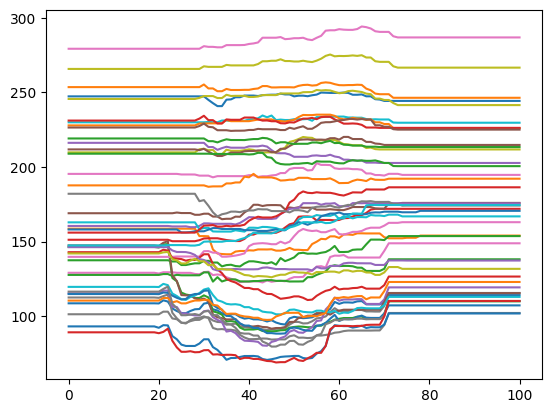

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# altering age
for i, x in diabetes.dev_x.iterrows():
    alternative = np.arange(0, 101, 1)  # possible values for age
    x_altered = np.tile(x.values, (len(alternative), 1))
    x_altered[:, 0] = alternative
    id_ = x.name
    cols = list(x.index)
    x_altered = pd.DataFrame(data=x_altered, columns=cols)
    pred = reg.predict(x_altered)
    plt.plot(alternative, pred)

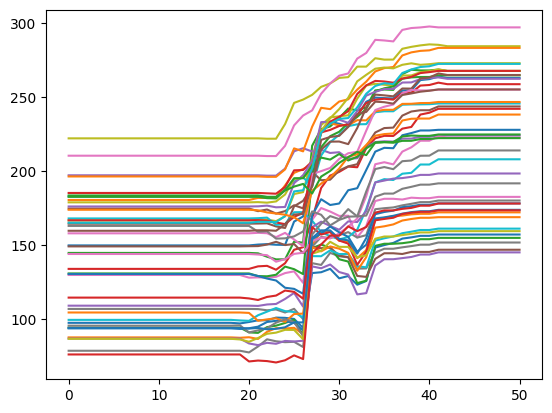

In [13]:
# for bmi
for i, x in diabetes.dev_x.iterrows():
    alternative = np.arange(0, 51, 1)
    x_altered = np.tile(x.values, (len(alternative), 1))
    x_altered[:, 1] = alternative
    id_ = x.name
    cols = list(x.index)
    x_altered = pd.DataFrame(data=x_altered, columns=cols)
    pred = reg.predict(x_altered)
    plt.plot(alternative, pred)

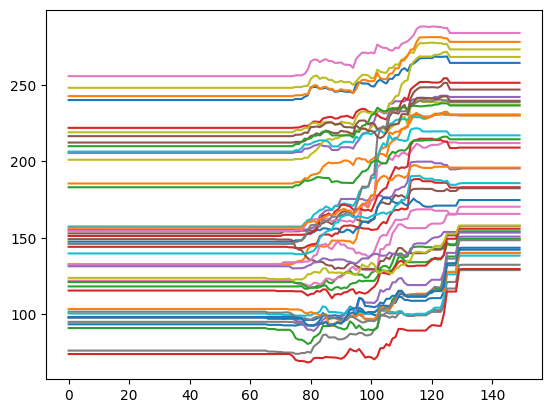

In [14]:
# for bp
for i, x in diabetes.dev_x.iterrows():
    alternative = np.arange(0, 150, 1)
    x_altered = np.tile(x.values, (len(alternative), 1))
    x_altered[:, 2] = alternative
    id_ = x.name
    cols = list(x.index)
    x_altered = pd.DataFrame(data=x_altered, columns=cols)
    pred = reg.predict(x_altered)
    plt.plot(alternative, pred)

## Counterfactual Explanations

A counterfactual explanation describes a causal situation in the form: “If X had not occurred, Y would not have occurred”.

__In machine learning, interpretations of a model's prediction that describe what would have happened if certain input features had different values.__ The idea is to understand why a model made a particular prediction for a given input by highlighting the features that were most influential in determining the outcome. A counterfactual explanation of a prediction describes the smallest change to the feature values that changes the prediction to a predefined output.

There are both __model-agnostic and model-specific counterfactual explanation methods__, but __we focus on model-agnostic__ methods.

We should have a __few criteria to determine if counterfactual explanation is good or bad__:
1. a counterfactual instance produces the predefined prediction as closely as possible
2. a counterfactual should be as similar as possible to the instance regarding feature values
3. often desirable to generate multiple diverse counterfactual explanations
4. a counterfactual instance should have feature values that are likely


### Wachter et al. (2017)

In order to generate counterfatual examples (__cfe.__), Wachter et al. proposed to minimize the following objective:

$$L(x,x',y',λ)=λ⋅\underbrace{(\hat{f}(x')-y')^2}_{\text{quadratic distance}} + \overbrace{d(x,x')}^{\text{distance of cfe.}}$$

The __first term is the quadratic distance between__ the __model prediction__ for the counterfactual $x’$ __and__ the __desired outcome__ $y’$, which the user must define in advance. The second term is the distance $d$ between the instance $x$ to be explained and the counterfactual $x’$. $λ$ balances the importance of the first or second term. __Higher $λ$ values mean__ that we prefer __closer solutions to__ the desired __prediction__ $y'$, __and a lower $λ$ means__ that we are __pursueing a similar example__ $x'$ to $x$.

The distance function __$d$ is defined as the Manhattan distance weighted with the inverse median absolute deviation (MAD)__ of each feature:

$$d(x,x')=\sum_{j=1}^{p}{\frac{|x_j-x_j'|}{\text{MAD}_j}},$$
where $p$ is the set of features. The proposed distance function has the __advantage over the Euclidean distance that it is more robust to outliers__. Scaling with the MAD is necessary to bring all the features to the same scale. Also MAD is defined as:

$$\text{MAD}_j=median_{i\in \{1,\dots,n\}}(|x_{i,j}-median_{l\in \{1,\dots,n\}}(x_{l,j})|),$$
where $n$ is the number of instances (data points).

Authors recommended that we should set a tolerance threshold $ϵ$ instead of setting $λ$, which can be done by including the following constraint:

$$|\hat{f}(x')-y'|\leq ϵ.$$

Thus, the final objective is as follows:
$$arg\,\underset{x'}{min}\,\underset{λ}{max}L(x,x',y',λ),$$
with a predetermined $ϵ$ threshold, the loss function is minimized for $x'$ and the (locally) optimal counterfactual $x'$ returned while increasing $λ$ until a sufficiently close solution is found.

However, __it has some disadvanteges__:
- generates non-diverse examples (3.)
- features values may take unlikely values (4.)
- does not handle categorical features with many different levels well

[Dandl et al. (2020)](https://arxiv.org/abs/2004.11165) addresses these problems, if you are interested have a look at the paper.

Reference:

[Counterfactual Explanations without Opening the Black Box: Automated Decisions and the GDPR](https://arxiv.org/abs/1711.00399)

## Local Interpretable Model-agnostic Explanations (LIME)

LIME builds on the premise of surrogate models. Surrogate models (in general) are trained to approximate the prediction of the underlying black-box model. LIME focuses on training a local surrogate model to explain individual predictions.

The idea and algorithm is pritty simple. Assume that you only have your already trained black-box model. LIME tests what happends to the preductions when you input variations of your data. Thus, it generates a new dataset by perturbing the samples of your original dataset. On this new dataset it trains a new interpretable model which approximates the decision of the original model. The interpretable model can be anything with intrinsic interpretability, such as a linear regression model or a decision tree model.

Formally, it can be written as:
$$\text{explanation}(x)=argmin_{g\in G} L(f,g,π_x)+Ω(g),$$
where for instance $x$ and black-box model $f$, we can provide an explanation with interpretable model $g$ that minimizes the loss $L$, while the model complexit $Ω(g)$ kept low. $π_x$ defines the neighbourhood around instance $x$ that we consider for the explanation.

In [15]:
import lime
from sklearn.pipeline import make_pipeline

c = make_pipeline(vectorizer, mnb)

c.predict_proba(dev_x)

array([[0.00742078, 0.99257922],
       [0.70888712, 0.29111288],
       [0.04910654, 0.95089346],
       ...,
       [0.10692066, 0.89307934],
       [0.9687849 , 0.0312151 ],
       [0.77610733, 0.22389267]])

In [16]:
from lime.lime_text import LimeTextExplainer

document_id = 6

explainer = LimeTextExplainer(class_names=['non-toxic', 'toxic'])
exp = explainer.explain_instance(dev_x.iloc[document_id], c.predict_proba, num_features=6)

print('Sentence: %s', dev_x.iloc[document_id])
print('Probability(toxic) =', c.predict_proba([dev_x.iloc[document_id]])[0, 1])
print('True class: %s' % class_names[dev_y.iloc[document_id]])

Sentence: %s happy at work *conference: right mindset leads to culture-of-development organizations    #work #mindset
Probability(toxic) = 2.5273744171022547e-05
True class: non-toxic


In [17]:
exp.as_list()

[('mindset', -0.011708088983876161),
 ('organizations', -0.010733126325889504),
 ('leads', -0.00799780825079024),
 ('conference', -0.006330035287237163),
 ('development', -0.006267856970359262),
 ('happy', -0.003083072727698576)]

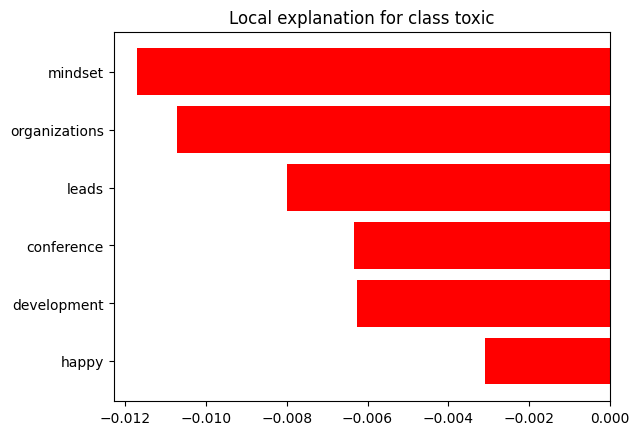

In [18]:
_ = exp.as_pyplot_figure()

In [19]:
exp.show_in_notebook(text=True)

## Scoped Rules (Anchors)

The "Anchors" method is a feature selection technique proposed by the authors of the LIME (Local Interpretable Model-Agnostic Explanations) algorithm. The goal of the method is to identify a minimal set of features, called "anchors", that can explain a prediction of a black-box model for any instance in the dataset. The intuition behind the method is that an anchor is a rule that, if it applies to an instance, ensures a certain prediction regardless of the other features. 

<img src="https://github.com/ficstamas/FateML/raw/master/notebooks/images/anchors-visualization.png" width=500>

The process of identifying anchors is done by solving an optimization problem that seeks to find the smallest set of rules that cover a large portion of the dataset while also accurately explaining the model's predictions. This allows Anchors to provide interpretable explanations for complex models by breaking down their predictions into a combination of simple if-then rules. An anchor is defined as:

$$\mathbb{E}_{\mathcal{D}_x(z\mid A)}\left[\mathbf{1}_{\hat{f}(x)=\hat{f}(z)}\right]\geq τ, A(x)=1$$

Given an instance $x$ to be explained, a rule or an anchor $A$ is to be found, such that it applies to $x$, while the same class as for $x$ gets predicted for a fraction of at least $τ$ ($0\leq \tau \leq 1$) of $x$’s neighbors where the same $A$ is applicable. A rule’s precision results from evaluating neighbors or perturbations (following $\mathcal{D}_x(z\mid A)$ which indicates the distribution of neighbors of $x$, matching $A$) using the provided machine learning model (denoted by the indicator function $\mathbf{1}_{\hat{f}(x)=\hat{f}(z)}$).

<img src="https://github.com/ficstamas/FateML/raw/master/notebooks/images/anchors-process.jpg" width=500>

References:

[github](https://github.com/marcotcr/anchor)

In [20]:
from anchor import anchor_text
import spacy

nlp = spacy.load('en_core_web_sm')

In [21]:
explainer = anchor_text.AnchorText(nlp, class_names, use_unk_distribution=True)

In [22]:
document_id = 3
document = dev_x.iloc[document_id]

exp = explainer.explain_instance(document, c.predict, threshold=0.95)

print('Sentence: %s' % document)
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('True label: %s' % class_names[dev_y.iloc[document_id]])
print('\nExamples where anchor applies and model predicts %s:' % class_names[dev_y.iloc[document_id]])
print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
print('\nExamples where anchor applies and model predicts %s:' % class_names[1 - dev_y.iloc[document_id]])
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

Sentence:  @user   #quotes #latenights #crying dness  i can never be me without being criticized. 
Anchor: latenights AND criticized AND quotes AND without AND @user AND dness AND .
Precision: 0.98
True label: non-toxic

Examples where anchor applies and model predicts non-toxic:
  @user    # quotes UNK latenights # crying dness UNK i can UNK be me without be
UNK @user    # quotes UNK latenights # crying dness UNK UNK UNK UNK UNK me witho
  @user UNK UNK quotes UNK latenights # UNK dness UNK i can UNK UNK me without U
UNK @user    UNK quotes UNK latenights # crying dness UNK UNK can never UNK me w
  @user UNK UNK quotes # latenights # crying dness UNK i can never UNK me withou
UNK @user    UNK quotes # latenights # crying dness UNK i can UNK be UNK without
UNK @user UNK # quotes # latenights # UNK dness   UNK UNK UNK be UNK without UNK
UNK @user    UNK quotes # latenights UNK UNK dness   i can UNK be me without bei
UNK @user UNK UNK quotes # latenights # UNK dness   i can UNK be UNK wi

## Shapley Values

Shapley value is a commonly used metric from coalitional game theory which describes how important is each player to the overall cooperation, and what payoff can he or she reasonably expect?

In machine learning, Shapley values are used to assign a contribution value to each feature in a prediction. The contribution of a feature is calculated based on the marginal contribution of the feature to the prediction, taking into account the contributions of all other features. This results in a fair and consistent assessment of the contribution of each feature to the prediction, even in the presence of complex interactions between features.

### Calculating Shapley value for one feature

To calculate the Shapley value for a single feature in a prediction, the following steps can be taken:

1. Consider a set of instances $X$ and a prediction function $f$ that maps instances to predictions.
2. For a specific feature $i$, calculate the marginal contribution of the feature to the prediction for each instance $x \in X$. This can be done by comparing the prediction made by the model with the prediction made when the feature is excluded (e.g., set to its mean value).
3. Consider all possible permutations of the feature set, and calculate the average marginal contribution of feature $i$ over all permutations. This is the Shapley value for the feature $i$.
4. Repeat the calculation for all features to obtain the Shapley value for each feature.

The computation of Shapley values can be computationally expensive, as it involves considering all possible feature permutations. However, there are approximations and algorithms available that can be used to reduce the computational complexity of the calculation, making it practical to use in real-world applications.

In [23]:
import itertools
import numpy as np
import warnings
import tqdm
import functools
from fateml.data import load_dataset
from sklearn.ensemble import RandomForestRegressor


@functools.lru_cache()
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)


@functools.lru_cache()
def number_of_combinations(n, r):
    return factorial(n) // (factorial(r) * factorial(n - r))
    

def calc_shapley(model, X, feature_index):
    n = X.shape[0]
    num_features = X.shape[1] - 1
    feature_values = X[:, feature_index]
    expected_value = feature_values.mean()
    expected_model_prediction = model.predict(X)
    
    # empty set is uncluded in `permutations`
    permutations = [x for x in itertools.chain.from_iterable(itertools.combinations(range(num_features), r) for r in range(num_features+1))]
    marginal_contribution = 0
    for permutation in tqdm.tqdm(permutations):
        if len(permutation) == 0:
            continue
        coalition_value = 0
        for i, feature_idx in enumerate(permutation):
            if feature_idx == feature_index:
                continue
            x_perm = X.copy()
            x_perm[:, feature_idx] = expected_value
            coalition_value += model.predict(x_perm)
        marginal_contribution += np.sum(coalition_value - expected_model_prediction) / len(X)
    return marginal_contribution / number_of_combinations(X.shape[0] - 1, len(permutations) - 2)


diabetes = load_dataset("diabetes", standardize=False, statsmodels_format=False, scaled=False)

features = ['age', 'bmi', 'bp', 's1']
reg = RandomForestRegressor(random_state=0)
reg.fit(diabetes.train_x[features], diabetes.train_y)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = []
    for i in range(len(features)):
        shap_values.append(calc_shapley(reg, diabetes.dev_x.values[:, :len(features)], i))

for f, s in zip(features, shap_values):
    print(f"{f}: {s}")

C:\Users\ftkni\AppData\Local\Temp\ipykernel_7704\1741502263.py:51: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(diabetes.train_x[features], diabetes.train_y)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 94.33it/s]

age: 7.7029614264292e-05
bmi: 1.5091224266672809e-05
bp: 0.00010413613165352125
s1: 0.00023459766343457417


<BarContainer object of 4 artists>

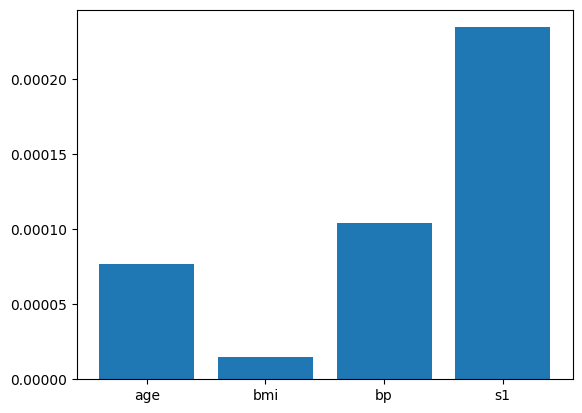

In [24]:
import matplotlib.pyplot as plt

plt.bar(features, shap_values)

### In a little bit more detail

The Shapley value is defined via a value function $val$ of players in $S$.

The Shapley value of a feature value is its contribution to the payout, weighted and summed over all possible feature value combinations:

$$ϕ_j(val)=\sum_{S⊆\{1,\dots,p\} \setminus \{j\}}{\frac{|S|!(p-|S|-1)!}{p!}(\underbrace{val(S∪\{j\})-val(S)}_{\text{change if $j$ joins}})},$$

where $S$ is a subset of the features used in the model, $x$ is the vector of feature values of the instance to be explained and $p$ the number of features. Furthermore, $val_x(S)$ is the prediction for feature values in set S that are marginalized over features that are not included in set S:

$$val_x(S)=\underbrace{∫\hat{f}(x_1,\dots,x_n)d\mathbb{P}_{x∉S}}_{\text{contribution of excluded features}}-\overbrace{E_X(\hat{f}(X))}^{\text{average contribution}}$$

### Attributes

__Efficiency:__ The feature contributions must add up to the difference of prediction for $x$ and the average.

__Symmetry:__ The contributions of two feature values $j$ and $k$ should be the same if they contribute equally to all possible coalitions.

__Dummy:__ A feature $j$ that does not change the predicted value – regardless of which coalition of feature values it is added to – should have a Shapley value of 0. 

__Additivity:__ Suppose you trained a random forest, which means that the prediction is an average of many decision trees. The Additivity property guarantees that for a feature value, you can calculate the Shapley value for each tree individually, average them, and get the Shapley value for the feature value for the random forest.

### Estimating Shapley Value

Due to the exponentially increasing possible sets of coalitions, the exact calculation of the Shapley Value becomes problematic. [Strumbelj et al. (2014)](https://link.springer.com/article/10.1007/s10115-013-0679-x) proposed an approximation with Monte-Carlo sampling:

$$\hat{ϕ}_j=\frac{1}{M}\sum_{m=1}^{M}\left(\hat{f}(x^m_{+j})-\hat{f}(x^m_{-j})\right),$$
where $\hat{f}(x^m_{+j})$ is the prediction for $x$, but with a random number of feature values replaced by feature values from a random data point $z$, except for the respective value of feature $j$. The $x$-vector $x^m_{-j}$ is almost identical to $x^m_{+j}$, but the value $x^m_{j}$ is also taken from the sampled $z$. 


__Approximate Shapley estimation for single feature value:__

- Output: Shapley value for the value of the $j$-th feature
- Required: Number of iterations $M$, instance of interest $x$, feature index $j$, data matrix $X$, and machine learning model $f$
  - For all $m = 1,…,M$:
    - Draw random instance $z$ from the data matrix $X$
    - Choose a random permutation $o$ of the feature values
    - Order instance $x: x_o=(x_{(1)},…,x_{(j)},…,x_{(p)})$
    - Order instance $z: z_o=(z_{(1)},…,z_{(j)},…,z_{(p)})$
    - Construct two new instances
      - With $j: x_{+j}=(x_{(1)},…,x_{(j−1)},x_{(j)},z_{(j+1)},…,z_{(p)})$
      - Without $j: x_{−j}=(x_{(1)},…,x_{(j−1)},z_{(j)},z_{(j+1)},…,z_{(p)})$
    - Compute marginal contribution: $ϕ^m_j=\hat{f}(x_{+j})−\hat{f}(x_{−j})$
- Compute Shapley value as the average: $ϕ_j(x)=\frac{1}{N}\sum_{m=1}^{M}ϕ_m$

## SHapley Additive exPlanations (SHAP)

SHAP (SHapley Additive exPlanations) is a unified and consistent framework for explaining the output of any machine learning model. It uses the concept of Shapley values from cooperative game theory to fairly distribute the contribution of each feature to the model's prediction for a particular instance. The result is an interpretable explanation of the prediction, showing how much each feature impacted the final outcome, positive or negative. Shapley value explanation is represented as an additive feature attribution method, a linear model. That view connects LIME and Shapley values. SHAP specifies the explanation as:

$$g(z')=ϕ_0+\sum_{j=1}^Mϕ_jz_j',$$

where $g$ is the explanation model, $z'∈\{0,1\}^M$ is the coalition vector, $M$ is the maximum coalition size and $ϕ_j∈\mathbb{R}$ is the feature attribution for a feature $j$. The SHAP values are unique in the sense that they ensure consistency, local accuracy, and missingness.

__Consistency:__ changing a model, so a feature has a larger impact on the model, will never decrease the attribution assigned to that feature. This ensures that the SHAP explanations are globally accurate, capturing the total impact of all features on the prediction.

__Local accuracy:__ the sum of the feature attributions is equal to the output of the model we are trying to explain. This makes SHAP a valuable tool for understanding the behavior of a machine learning model in a particular context.

__Missingness:__ refers to the situation where some features are missing or unavailable for an instance. In such cases, it is important to ensure that the explanations produced by the model are still meaningful and consistent. This allows SHAP to produce meaningful and trustworthy explanations even when some features are not present.

### KernelSHAP

KernelSHAP estimates for an instance $x$ the contributions of each feature value to the prediction. KernelSHAP consists of five steps:

- Sample coalitions $z'_k∈\{0,1\}^M, k∈\{1,…,K\}$ (1 = feature present in coalition, 0 = feature absent).
- Get prediction for each $z'_k$ by first converting $z'_k$ to the original feature space and then applying model $\hat{f}:\hat{f}(h_x(z'_k))$, where $h_x:\{0,1\}^M \rightarrow \mathbb{R}^p$
- Compute the weight for each $z'_k$ with the SHAP kernel.
- Fit weighted linear model.
- Return Shapley values $ϕ_k$, the coefficients from the linear model.

By repeated coin flips, we can make random coalitions $z'_k∈\{0,1\}^M$. With the generated coalitions, we are going to train a linear model which predicts values of certain coalitions. To get from coalitions of feature values to valid data instances, we need a function $h_x(z')=z$ where $h_x: \{0,1\}^M\rightarrow \mathbb{R}^p$. If a a coalition vector is 0 in $z'$ then we are going to randomly substitute it with another value from the dataset.

<img src="https://github.com/ficstamas/FateML/raw/master/notebooks/images/shap-simplified-features.jpg" width=500>

When we sample from the marginal distribution to estimate Shapley values, we run into a problem. This method ignores the relationship between the present and absent features, which can lead to skewed results. For example, unlikely instances may be given too much weight.

A solution to this issue is to sample from the conditional distribution instead. This changes the game that the Shapley values correspond to, and it also changes their interpretation. For example, a feature that may not have been used by the model at all could have a non-zero Shapley value when we use conditional sampling. In the marginal game, this feature would always have a Shapley value of 0, since it would go against the Dummy axiom otherwise.

### TreeSHAP

TreeSHAP was introduced as a fast, model-specific alternative to KernelSHAP, but it turned out that it can produce unintuitive feature attributions. TreeSHAP defines a conditionl expectation:

$$E_{X_j|X_{-j}}(\hat{f}(x)\mid x_j)$$

The problem with the conditional expectation is that features that have no influence on the prediction function $f$ can get a TreeSHAP estimate different from zero. The non-zero estimate can happen when the feature is correlated with another feature that actually has an influence on the prediction.

### Text Classification

In [25]:
import shap
from scipy.sparse import csr_array
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
    
vectorizer = TfidfVectorizer(min_df=20)
train_x_vec = vectorizer.fit_transform(train_x)
dev_x_vec = vectorizer.transform(dev_x)
test_x_vec = vectorizer.transform(test_x)

mnb = LogisticRegression(penalty="l1", C=0.1, solver="saga")
mnb.fit(train_x_vec, train_y)

LogisticRegression(C=0.1, penalty='l1', solver='saga')

In [32]:
from sklearn.metrics import classification_report

test_preds = mnb.predict(dev_x_vec)
print(classification_report(dev_y, test_preds, target_names=['non-toxic', 'toxic']))

              precision    recall  f1-score   support

   non-toxic       0.89      0.98      0.93      3305
       toxic       0.97      0.83      0.90      2370

    accuracy                           0.92      5675
   macro avg       0.93      0.91      0.92      5675
weighted avg       0.92      0.92      0.92      5675



In [26]:
feature_names = vectorizer.get_feature_names_out()
explainer = shap.LinearExplainer(mnb, train_x_vec, seed=0, feature_names=feature_names)

In [27]:
shap_values = explainer(dev_x_vec.toarray())

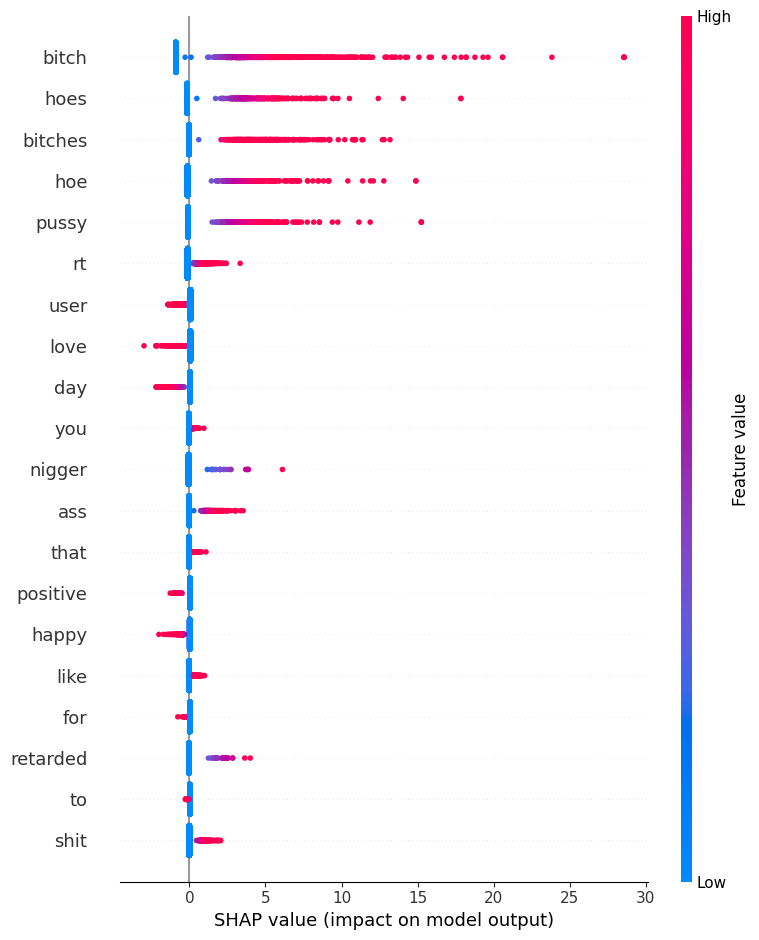

In [28]:
shap.summary_plot(shap_values, dev_x_vec.toarray(), feature_names=feature_names)

In [ ]:
ind = 0
shap.plots.force(
    shap_values[ind, :], feature_names=feature_names
)